In [ ]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator
from PIL import Image

# SDXL unCLIP requires code from https://github.com/Stability-AI/generative-models/tree/main
sys.path.append('generative_models/')
import sgm
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder, FrozenOpenCLIPEmbedder2
from generative_models.sgm.models.diffusion import DiffusionEngine
from generative_models.sgm.util import append_dims
from omegaconf import OmegaConf

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import utils
from models import *

accelerator = Accelerator(split_batches=False, mixed_precision="fp16")
device = accelerator.device
print("device:",device)

In [ ]:
# if running this interactively, can specify jupyter_args here for argparser to use
plotting = False
if utils.is_interactive():
    model_name = "fmri_init_use_difussion_prior_2GPUS_1SUBJ"
    print("model_name:", model_name)

    # other variables can be specified in the following string:
    jupyter_args = f'--data_path=/net/pr2/projects/plgrid/plggrai/kzrobek/MindEyeV2/data \
                    --ckpt_path=../train_logs/{model_name}/last.pth \
                    --model_name={model_name} \
                    --subj=1 \
                    --hidden_dim=1024 \
                    --n_blocks=4 \
                    --new_test \
                    --batch_size=4'
    print(jupyter_args)
    jupyter_args = jupyter_args.split()
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

In [73]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="will load ckpt for model found in ../train_logs/model_name",
)
parser.add_argument(
    "--data_path", type=str, default=os.getcwd(),
    help="Path to where NSD data is stored / where to download it to",
)
parser.add_argument(
    "--cache_dir", type=str, default=os.getcwd(),
    help="Path to where misc. files downloaded from huggingface are stored. Defaults to current src directory.",
)
parser.add_argument(
    "--ckpt_path", type=str, default=os.getcwd(),
    help="Path to model checkpoint.",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,3,4,5,6,7,8],
    help="Validate on which subject?",
)
parser.add_argument(
    "--blurry_recon",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--n_blocks",type=int,default=4,
)
parser.add_argument(
    "--hidden_dim",type=int,default=2048,
)
parser.add_argument(
    "--new_test",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--seed",type=int,default=42,
)
parser.add_argument(
    "--batch_size",type=int,default=4,
)
if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)
    
# seed all random functions
utils.seed_everything(seed)

# make output directory
os.makedirs("evals",exist_ok=True)
os.makedirs(f"evals/{model_name}",exist_ok=True)

# Load Test Data

In [95]:
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

class Data4Model(torch.utils.data.Dataset):
    def __init__(self, state='training', sub_id=1, transform=None):
        
        super(Data4Model, self).__init__()
       
        imgs = np.load(f'{data_path}/GetData/'+state+'_imgpaths.npy').tolist()
        
        eeg = np.load(f'{data_path}/PreprocessedEEG/sub-'+str(sub_id).zfill(2)+'/preprocessed_eeg_'+state+'.npy', allow_pickle=True).tolist()
        eeg = eeg['preprocessed_eeg_data']
        eeg = np.mean(eeg, axis=1)
        eeg = eeg[:, np.r_[11:19, 43:52], 20:40] #take only 17 channels
        self.imgs = imgs
        self.eeg = torch.Tensor(eeg).to('cpu')
        self.transform = transform
  
    def __len__(self):
        return min(len(self.imgs), len(self.eeg))
    
    def __getitem__(self, item):
        imgs = self.transform(Image.open(self.imgs[item]).convert('RGB'))
        eeg = torch.tensor(self.eeg[item])
        return eeg, imgs

In [96]:
from torch.utils.data import DataLoader


test_data = Data4Model(state='test', sub_id=subj, transform=transform)
num_test = len(test_data)
test_dl = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=True)
    
print(f"Loaded test dl for subject {subj}!\n")
print(f"test cases: {num_test}")

Loaded test dl for subject 1!

test cases: 200


### Check eeg input dim

In [97]:
eeg_example, _ = next(iter(test_dl))

print("EEG shape ", eeg_example.shape)
eeg_example = eeg_example.view(batch_size, -1) # batch_size x(im repetitions) x channels x  timepoints
eeg_input_dim = eeg_example.shape[1]
print("eeg_input_dim ", eeg_input_dim)
print("hidden_dim", hidden_dim)

EEG shape  torch.Size([4, 17, 20])
eeg_input_dim  340
hidden_dim 1024


/net/tscratch/people/plgkzrobek/slurm_jobdir/1129552/tmp.t0025/ipykernel_3069583/3381101559.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eeg = torch.tensor(self.eeg[item])


### Prepare model

In [98]:
clip_img_embedder = FrozenOpenCLIPImageEmbedder(
    arch="ViT-bigG-14",
    version="laion2b_s39b_b160k",
    output_tokens=True,
    only_tokens=True,
)
clip_img_embedder.to(device)
clip_seq_dim = 256
clip_emb_dim = 1664

if blurry_recon:
    from huggingface_hub import hf_hub_download
    from diffusers import AutoencoderKL    
    autoenc = AutoencoderKL(
        down_block_types=['DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D'],
        up_block_types=['UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D'],
        block_out_channels=[128, 256, 512, 512],
        layers_per_block=2,
        sample_size=256,
    )
    # Download the Autoencoder checkpoint from Hugging Face
    autoenc_ckpt_path = hf_hub_download(repo_id='pscotti/mindeyev2', filename='sd_image_var_autoenc.pth', repo_type='dataset')
    ckpt = torch.load(autoenc_ckpt_path)
    autoenc.load_state_dict(ckpt)
    
    autoenc.eval()
    autoenc.requires_grad_(False)
    autoenc.to(device)
    utils.count_params(autoenc)
    
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    def forward(self, x):
        return x
        
model = MindEyeModule()


class RidgeRegressionEEG(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer to enable regularization
    def __init__(self, input_size, out_features, subj_list): 
        super(RidgeRegressionEEG, self).__init__()
        self.out_features = out_features
        self.linears = torch.nn.ModuleList([
                torch.nn.Linear(input_size, out_features) for _ in subj_list
            ])
    def forward(self, x, subj_idx):
        out = self.linears[subj_idx](x[:,0]).unsqueeze(1)
        return out
        
model.ridge = RidgeRegressionEEG(eeg_input_dim, out_features=hidden_dim, subj_list=[subj])

from diffusers.models.vae import Decoder
from models import BrainNetwork
model.backbone = BrainNetwork(h=hidden_dim, in_dim=hidden_dim, seq_len=1, 
                          clip_size=clip_emb_dim, out_dim=clip_emb_dim*clip_seq_dim) 
utils.count_params(model.ridge)
utils.count_params(model.backbone)
utils.count_params(model)

# setup diffusion prior network
out_dim = clip_emb_dim
depth = 6
dim_head = 52
heads = clip_emb_dim//52 # heads * dim_head = clip_emb_dim
timesteps = 100

prior_network = PriorNetwork(
        dim=out_dim,
        depth=depth,
        dim_head=dim_head,
        heads=heads,
        causal=False,
        num_tokens = clip_seq_dim,
        learned_query_mode="pos_emb"
    )

model.diffusion_prior = BrainDiffusionPrior(
    net=prior_network,
    image_embed_dim=out_dim,
    condition_on_text_encodings=False,
    timesteps=timesteps,
    cond_drop_prob=0.2,
    image_embed_scale=None,
)
model.to(device)

utils.count_params(model.diffusion_prior)
utils.count_params(model)


param counts:
83,653,863 total
0 trainable
param counts:
349,184 total
349,184 trainable
param counts:
458,885,116 total
458,885,116 trainable
param counts:
459,234,300 total
459,234,300 trainable
param counts:
259,865,216 total
259,865,200 trainable
param counts:
719,099,516 total
719,099,500 trainable


719099500

## Load pretrained model ckpt

In [99]:
def load_ckpt(tag, ckpt_path, load_lr=True,load_optimizer=True,load_epoch=True,strict=True,multisubj_loading=False): 
    print(f"\n---loading {ckpt_path} ckpt---\n")
    checkpoint = torch.load(ckpt_path, map_location='cpu')
    state_dict = checkpoint['model_state_dict']
    if multisubj_loading: # remove incompatible ridge layer that will otherwise error
        state_dict.pop('ridge.linears.0.weight',None)
    model.load_state_dict(state_dict, strict=strict)
    if load_epoch:
        globals()["epoch"] = checkpoint['epoch']
        print("Epoch",epoch)
    if load_optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if load_lr:
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    del checkpoint
    print(f"checkpoint loaded!")

load_ckpt("last",cktp_path, load_lr=False,load_optimizer=False,load_epoch=False,strict=False,multisubj_loading=True)

NameError: name 'cktp_path' is not defined

## Setup text caption networks

In [79]:
from huggingface_hub import hf_hub_download
from transformers import AutoProcessor, AutoModelForCausalLM
from modeling_git import GitForCausalLMClipEmb
processor = AutoProcessor.from_pretrained("microsoft/git-large-coco")
clip_text_model = GitForCausalLMClipEmb.from_pretrained("microsoft/git-large-coco")
clip_text_model.to(device) # if you get OOM running this script, you can switch this to cpu and lower minibatch_size to 4
clip_text_model.eval().requires_grad_(False)
clip_text_seq_dim = 257
clip_text_emb_dim = 1024

class CLIPConverter(torch.nn.Module):
    def __init__(self):
        super(CLIPConverter, self).__init__()
        self.linear1 = nn.Linear(clip_seq_dim, clip_text_seq_dim)
        self.linear2 = nn.Linear(clip_emb_dim, clip_text_emb_dim)
    def forward(self, x):
        x = x.permute(0,2,1)
        x = self.linear1(x)
        x = self.linear2(x.permute(0,2,1))
        return x
        
clip_convert = CLIPConverter()
clip_convert_ckpt_path = hf_hub_download(repo_id='pscotti/mindeyev2', filename='bigG_to_L_epoch8.pth', repo_type='dataset')
state_dict = torch.load(clip_convert_ckpt_path, map_location='cpu')['model_state_dict']
clip_convert.load_state_dict(state_dict, strict=True)
clip_convert.to(device) # if you get OOM running this script, you can switch this to cpu and lower minibatch_size to 4
del state_dict

/net/pr2/projects/plgrid/plggrai/kzrobek/MindEyeV2/fmri/lib64/python3.9/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Prep unCLIP

In [80]:
config = OmegaConf.load("generative_models/configs/unclip6.yaml")
config = OmegaConf.to_container(config, resolve=True)
unclip_params = config["model"]["params"]
network_config = unclip_params["network_config"]
denoiser_config = unclip_params["denoiser_config"]
first_stage_config = unclip_params["first_stage_config"]
conditioner_config = unclip_params["conditioner_config"]
sampler_config = unclip_params["sampler_config"]
scale_factor = unclip_params["scale_factor"]
disable_first_stage_autocast = unclip_params["disable_first_stage_autocast"]
offset_noise_level = unclip_params["loss_fn_config"]["params"]["offset_noise_level"]

first_stage_config['target'] = 'sgm.models.autoencoder.AutoencoderKL'
sampler_config['params']['num_steps'] = 38

diffusion_engine = DiffusionEngine(network_config=network_config,
                       denoiser_config=denoiser_config,
                       first_stage_config=first_stage_config,
                       conditioner_config=conditioner_config,
                       sampler_config=sampler_config,
                       scale_factor=scale_factor,
                       disable_first_stage_autocast=disable_first_stage_autocast)
# set to inference
diffusion_engine.eval().requires_grad_(False)
diffusion_engine.to(device)

diffusion_engine_ckpt_path = hf_hub_download(repo_id='pscotti/mindeyev2', filename='unclip6_epoch0_step110000.ckpt', repo_type='dataset')
ckpt = torch.load(diffusion_engine_ckpt_path, map_location='cpu')
diffusion_engine.load_state_dict(ckpt['state_dict'])

batch={"jpg": torch.randn(1,3,1,1).to(device), # jpg doesnt get used, it's just a placeholder
      "original_size_as_tuple": torch.ones(1, 2).to(device) * 768,
      "crop_coords_top_left": torch.zeros(1, 2).to(device)}
out = diffusion_engine.conditioner(batch)
vector_suffix = out["vector"].to(device)
print("vector_suffix", vector_suffix.shape)

Initialized embedder #0: FrozenOpenCLIPImageEmbedder with 1909889025 params. Trainable: False
Initialized embedder #1: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #2: ConcatTimestepEmbedderND with 0 params. Trainable: False
vector_suffix torch.Size([1, 1024])


In [81]:
print(model)

MindEyeModule(
  (ridge): RidgeRegressionEEG(
    (linears): ModuleList(
      (0): Linear(in_features=6300, out_features=1024, bias=True)
    )
  )
  (backbone): BrainNetwork(
    (mixer_blocks1): ModuleList(
      (0-3): 4 x Sequential(
        (0): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (1): Sequential(
          (0): Linear(in_features=1024, out_features=1024, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.15, inplace=False)
          (3): Linear(in_features=1024, out_features=1024, bias=True)
        )
      )
    )
    (mixer_blocks2): ModuleList(
      (0-3): 4 x Sequential(
        (0): LayerNorm((1,), eps=1e-05, elementwise_affine=True)
        (1): Sequential(
          (0): Linear(in_features=1, out_features=1, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.15, inplace=False)
          (3): Linear(in_features=1, out_features=1, bias=True)
        )
      )
    )
    (backbone_linear): Linea

# Make Inference

  0%|          | 0/50 [00:00<?, ?it/s]/net/tscratch/people/plgkzrobek/slurm_jobdir/1129552/tmp.t0025/ipykernel_3069583/3381101559.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eeg = torch.tensor(self.eeg[item])


sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a close up................', 'a close to a close to a wall.', 'a small.................', 'a wall at the end of a building.']


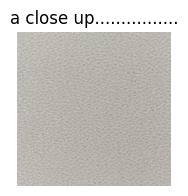

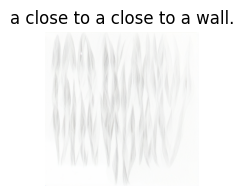

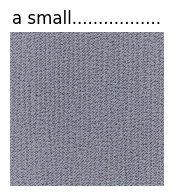

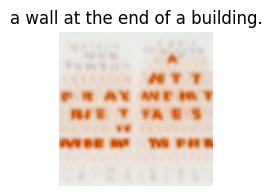

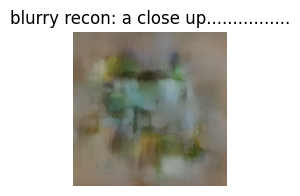

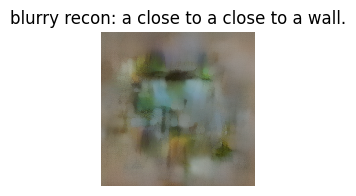

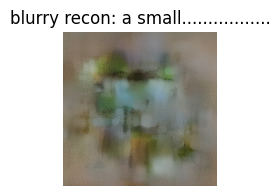

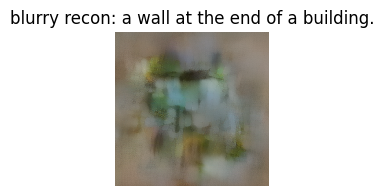

  2%|▏         | 1/50 [00:22<18:11, 22.28s/it]

fmri_init_use_difussion_prior_2GPUS_1SUBJ


sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a little over a little.', 'a close to the roof.', 'a.', 'a close up................']


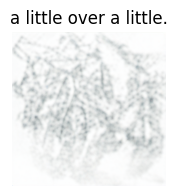

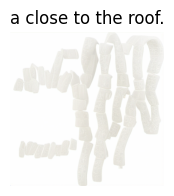

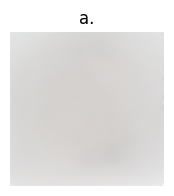

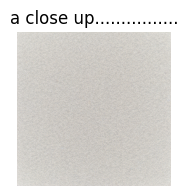

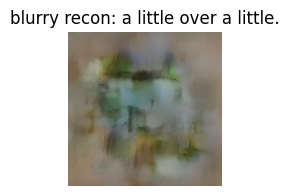

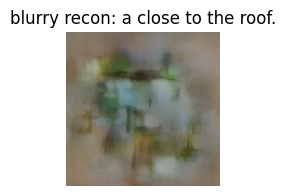

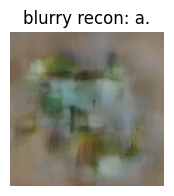

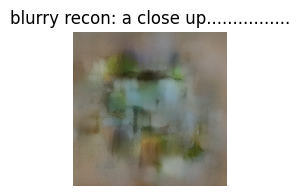

  4%|▍         | 2/50 [00:44<17:46, 22.23s/it]

fmri_init_use_difussion_prior_2GPUS_1SUBJ


sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a..................', 'a..................', 'the sc.................', 'a big w / a big w w w w w w w w w w w w w']


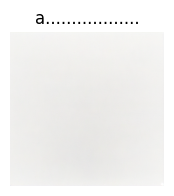

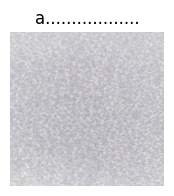

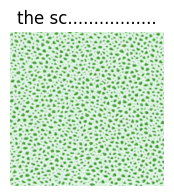

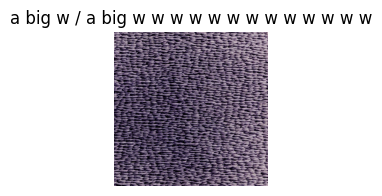

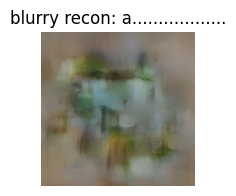

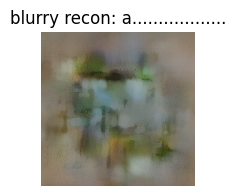

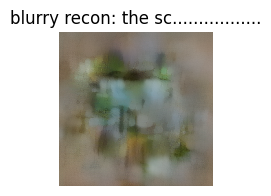

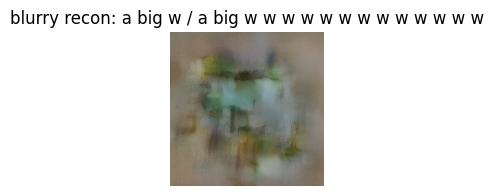

  6%|▌         | 3/50 [01:06<17:26, 22.27s/it]

fmri_init_use_difussion_prior_2GPUS_1SUBJ


sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a..................', 'a night and looking up and looking up and looking and looking and looking and looking and looking and', 'a [ unused0 ]', 'a..................']


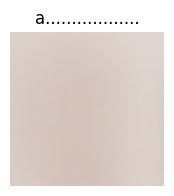

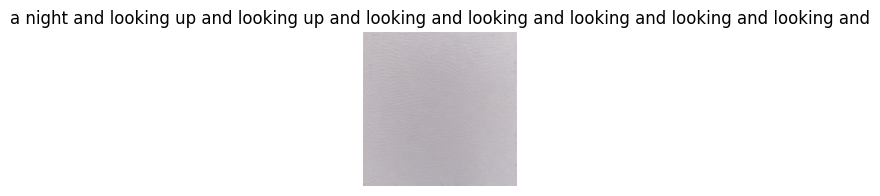

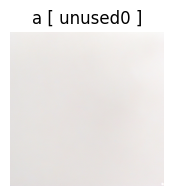

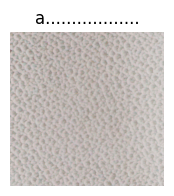

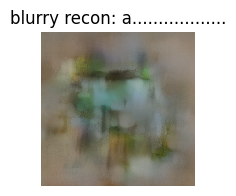

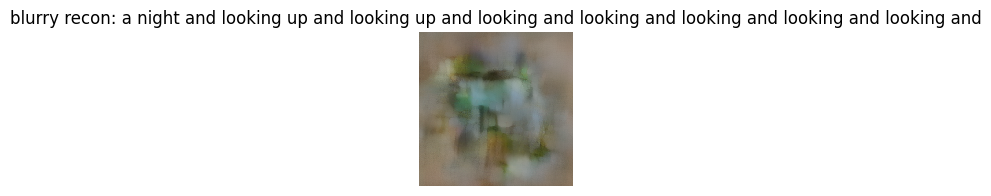

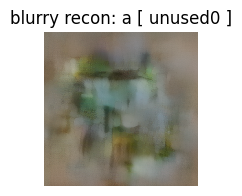

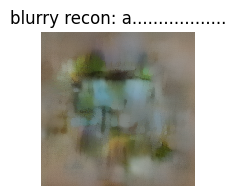

  8%|▊         | 4/50 [01:29<17:04, 22.27s/it]

fmri_init_use_difussion_prior_2GPUS_1SUBJ


sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a little over a little.', 'a close by a close by a close by a close by.', 'a close to the green..............', 'a close to the ground.']


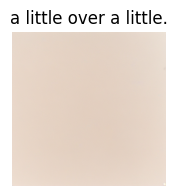

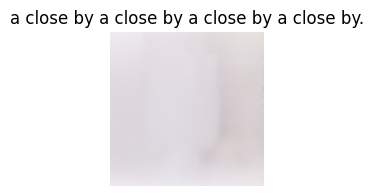

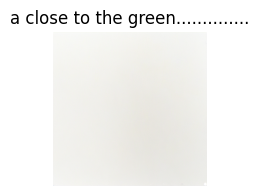

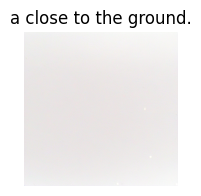

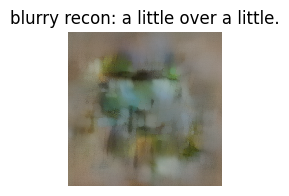

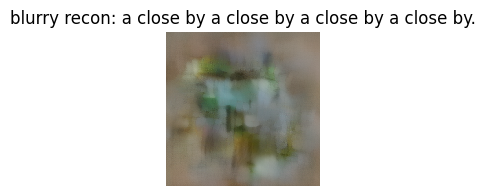

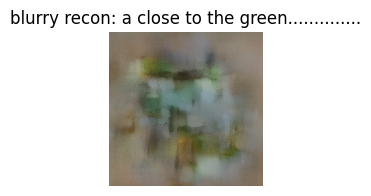

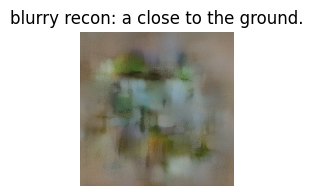

 10%|█         | 5/50 [01:51<16:42, 22.29s/it]

fmri_init_use_difussion_prior_2GPUS_1SUBJ


sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

 10%|█         | 5/50 [01:52<16:49, 22.42s/it]

["a close up of a person's face", 'a night.................', 'a close to the roofing a house.', 'a close to the ground in the early.']


KeyboardInterrupt: 

In [100]:
# get all reconstructions
model.to(device)
model.eval().requires_grad_(False)

# all_images = None
all_blurryrecons = None
all_recons = None
all_predcaptions = []
all_clipeeg = None

minibatch_size = 1
num_samples_per_image = 1
assert num_samples_per_image == 1

if utils.is_interactive(): plotting=True

with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16):
    for eeg, imgs in tqdm(test_dl):

        eeg = eeg.to(device) 
        image = imgs.to(device)
        eeg_ridge = model.ridge(eeg.view(batch_size,-1).unsqueeze(1), 0)

        backbone, clip_eeg, blurry_image_enc = model.backbone(eeg_ridge)

             
        # Save retrieval submodule outputs
        if all_clipeeg is None:
            all_clipeeg = clip_eeg.cpu()
        else:
            all_clipeeg = torch.vstack((all_clipeeg, clip_eeg.cpu()))
        
        # Feed eeg through OpenCLIP-bigG diffusion prior
        prior_out = model.diffusion_prior.p_sample_loop(backbone.shape, 
                        text_cond = dict(text_embed = backbone), 
                        cond_scale = 1., timesteps = 20)
        
        pred_caption_emb = clip_convert(prior_out)
        generated_ids = clip_text_model.generate(pixel_values=pred_caption_emb, max_length=20)
        generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)
        all_predcaptions = np.hstack((all_predcaptions, generated_caption))
        print(generated_caption)
        
        # Feed diffusion prior outputs through unCLIP
        for i in range(len(eeg)):
            samples = utils.unclip_recon(prior_out[[i]],
                             diffusion_engine,
                             vector_suffix,
                             num_samples=num_samples_per_image)
            if all_recons is None:
                all_recons = samples.cpu()
            else:
                all_recons = torch.vstack((all_recons, samples.cpu()))
            if plotting:
                for s in range(num_samples_per_image):
                    plt.figure(figsize=(2,2))
                    plt.title(generated_caption[i])
                    plt.imshow(transforms.ToPILImage()(samples[s]))
                    plt.axis('off')
                    plt.show()

        if blurry_recon:
            image_enc_pred, _ = blurry_image_enc
            blurred_image = (autoenc.decode(image_enc_pred/0.18215).sample/ 2 + 0.5).clamp(0,1)
            
            for i in range(len(eeg)):
                im = torch.Tensor(blurred_image[i])
                if all_blurryrecons is None:
                    all_blurryrecons = im[None].cpu()
                else:
                    all_blurryrecons = torch.vstack((all_blurryrecons, im[None].cpu()))
                if plotting:
                    plt.figure(figsize=(2,2))
                    plt.title(f"blurry recon: {generated_caption[i]}")
                    plt.imshow(transforms.ToPILImage()(im))
                    plt.axis('off')
                    plt.show()

        if plotting: 
            print(model_name)
            #break # dont actually want to run the whole thing with plotting=True

if not utils.is_interactive():
    # resize outputs before saving
    imsize = 256
    all_recons = transforms.Resize((imsize,imsize))(all_recons).float()
    if blurry_recon: 
        all_blurryrecons = transforms.Resize((imsize,imsize))(all_blurryrecons).float()
            
    # saving
    print(all_recons.shape)
    # # You can find the all_images file on huggingface: https://huggingface.co/datasets/pscotti/mindeyev2/tree/main/evals
    # torch.save(all_images,"evals/all_images.pt") 
    if blurry_recon:
        torch.save(all_blurryrecons,f"evals/{model_name}/{model_name}_all_blurryrecons.pt")
    torch.save(all_recons,f"evals/{model_name}/{model_name}_all_recons.pt")
    torch.save(all_predcaptions,f"evals/{model_name}/{model_name}_all_predcaptions.pt")
    torch.save(all_clipeeg,f"evals/{model_name}/{model_name}_all_clipeeg.pt")
    print(f"saved {model_name} outputs!")
